# Air Pollution Forecasting Using Machine Learning

Sofia Pignataro 67523  <br>
Felix Otter 65284<br> 
Davide Dal Cero 64018 <br>
Francisco Manuel Nunes Mendes da Costa 67754 <br>
Moritz MÜller 67194 <br>
LÉon Philipp Klingele 67163 <br>



# Table of Contents

- 1. [Data Import](#1-data-import)
- 2. [Exploartory Data Analysis](#2-exploratory-data-analysis)
  - 2.1 [Data Cleaning](#21-data-cleaning)
  - 2.2 [Data Exploration](#22-data-exploration)
  - 2.3 [Numerical Histogram](#23-histogram)
  - 2.4 [Correlation Matrix](#24-correlation-matrix)
  - 2.5 [Time Series Analysis](#25-time-series-analysis)
  - 2.6 [Wind Analysis](#27-wind-direction-analysis)
- 3. [Feature Engineering for the first trial](#3-feature-engineering-for-the-first-trial)
- 4. [Our first trials](#4-our-first-trials---models)
- 5. [Next Approach: Attempt with daily aggregation](#5-next-approach-attempt-with-daily-aggregation)
  - 5.1 [Regression before classifcication](#51-regression-before-classification)
  - 5.2 [Classification](#52-classification)

- 6. [Our final attempt](#6-final-approach)
  - 6.1 [Random Forest (Our final model we chose)](#61-random-forest)
  - 6.2 [XGBoost](#62-xgboost)


# 1. Data Import


## Brief Summary about the Dataset:

- ``Date``: Hourly Data (e.g 2010-01-02 00:00:00), reaching from '2010-01-02 00:00:00', '2014-12-31 23:00:00'
- ``Pollution``: Level of Pollution
- ``Dew``: Temperature at which the Air becomes saturated with 100% moisture
- ``Temp``: Temperature
- ``Press``: Air pressure
- ``Wnd_dir``: Wind direction
- ``Wnd_spd``: Wind speed
- ``Snow``: CMs of Snow #Assumption
- ``Rain``: MMs of Rain #Assumption


In [110]:
dataset_url = "https://raw.githubusercontent.com/davidedalce/Air-Quality-Forecast/main/data/LSTM-Multivariate_pollution.csv"
df = pd.read_csv(dataset_url)

In [111]:
df_pollution=df

# 2. Exploratory Data Analysis

In [112]:
df_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [113]:
df_pollution['date'] = pd.to_datetime(df_pollution['date'])
df_pollution.set_index('date', inplace=True)
df_pollution.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## 2.1 Data Cleaning

In [114]:
def data_cleaning(df):
        """
        Cleans the dataset by removing missing values and duplicates.
        Updates the class instance with the cleaned DataFrame.
        """
        if df.isna().sum().any():
            print(f"Columns with missing values:\n{df.isna().sum()}")
            df = df.dropna()
        else:
            print("No missing values found 🚀")

        if df.duplicated().any():
            print(f"Duplicate rows found: {df[df.duplicated()]}")
            df = df.drop_duplicates()
        else:
            print("No duplicates found 🚀")

        print("Data has been cleaned 🥳")
        return df

In [115]:
print("=== Checking and Cleaning Data for the Pollution Dataset === \n")
df_pollution = data_cleaning(df_pollution)


=== Checking and Cleaning Data for the Pollution Dataset === 

No missing values found 🚀
Duplicate rows found:                      pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-06-19 04:00:00       98.0   16  18.0  1005.0      SE     0.89     0     0
2010-09-30 07:00:00        0.0    8   9.0  1019.0      NW     0.89     0     0
2012-08-07 22:00:00       79.0   25  28.0  1006.0      cv     0.89     0     0
2012-08-24 03:00:00       81.0   17  18.0  1013.0      cv     1.78     0     0
2013-04-04 09:00:00       92.0   -5  10.0  1015.0      cv     0.89     0     0
2013-05-18 06:00:00        0.0   13  17.0  1008.0      cv     0.89     0     0
2013-08-11 02:00:00       80.0   24  27.0  1006.0      SE     3.58     0     0
2013-09-19 04:00:00      114.0   17  20.0  1014.0      SE     3.58     0     0
2013-10-10 04:00:00      203.0   11  14.0  1006.0      cv     0.89     0     0
2013-11-19 11:00:00 

## 2.2 Data Exploration

In [33]:
def find_uniques(df):

        """
        Prints the unique entries in a dataframe

        """

        for col in df.columns:

            bold_col = f"\033[1m{col}\033[0m"

            if df[col].dtype in ["int64", "float64"]:
                print(f"{bold_col}: has {df[col].nunique()} unique values \n")

            else:
                print(f"{bold_col}: has unique {df[col].nunique()} values: {df[col].unique()} \n") #check why snow / rain is in there

In [34]:
print("=== Checking and Cleaning Data for the Pollution Dataset === \n")
find_uniques(df_pollution)

print("\n=== Checking and Cleaning Data for the Pollution Test Dataset  ===\n")
find_uniques(df_pollution_test)

=== Checking and Cleaning Data for the Pollution Dataset === 

pollution: has 581 unique values 

dew: has 69 unique values 

temp: has 64 unique values 

press: has 60 unique values 

wnd_dir: has unique 4 values: ['SE' 'cv' 'NW' 'NE'] 

wnd_spd: has 2788 unique values 

snow: has 28 unique values 

rain: has 37 unique values 


=== Checking and Cleaning Data for the Pollution Test Dataset  ===

dew: has 20 unique values 

temp: has 21 unique values 

press: has 25 unique values 

wnd_dir: has unique 4 values: ['SE' 'cv' 'NE' 'NW'] 

wnd_spd: has 187 unique values 

snow: has 1 unique values 

rain: has 1 unique values 

pollution: has 178 unique values 



## 2.3 Histogram



The following histograms represent the distribution of various environmental variables, likely measured in Beijing based on the context of your previous windrose analysis. Each histogram provides insight into the frequency of occurrence of different values for the respective variables. Here's a brief interpretation:

- **Pollution**: The distribution is right-skewed, with a significant peak around 200-300 units, suggesting that lower to moderate pollution levels are most common. Higher pollution levels (above 600) occur less frequently but still contribute to a notable portion of the data.

- **Dew**: This variable shows a roughly normal distribution centered around 0° to 10°, with a high frequency of occurrences in this range. There are fewer instances of extreme dew values (below -30° or above 30°), indicating a stable dew point range.

- **Temperature (temp)**: The temperature data exhibits a bimodal distribution with peaks around -10° to 0° and 20° to 30° units, suggesting two dominant temperature regimes, possibly reflecting seasonal variations (e.g., winter and summer).

- **Pressure (press)**: The pressure histogram is centered around 1010-1020 hpa, with a bell-shaped distribution, indicating that atmospheric pressure is relatively stable with most values clustering around this range.

- **Wind Speed (wnd_spd)**: Wind speed is highly skewed, with the vast majority of values near 0, and a sharp drop-off as speed increases beyond 100 ?. This suggests predominantly calm conditions with occasional higher wind speeds.

- **Snow**: The snow data is heavily skewed, with a peak near 0cms, indicating that snow is rare or minimal for most observations, with very few instances exceeding 10cms units.

- **Rain**: Similar to snow, the rain histogram is skewed, with a dominant peak at 0, suggesting that rain is infrequent or negligible in most cases, with very few occurrences above 5 mm. Furthermore, in Times of Rain there is no Snow, and in Periods of Snow there is no Rain, therefore signaling the different season

In [35]:
cat_cols =  []
num_cols = []

for col in df_pollution.columns:
    if df_pollution[col].dtype in ["categorical", "object"]:
        cat_cols.append(col)
    else:
        num_cols.append(col)

print(f"Cat Cols: \n {cat_cols} \n")
print(f'Numerical Cols: \n {num_cols}')


Cat Cols: 
 ['wnd_dir'] 

Numerical Cols: 
 ['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']


C:\Users\z003xbyx\AppData\Local\Temp\ipykernel_11364\2874324600.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_pollution.hist(ax = ax)


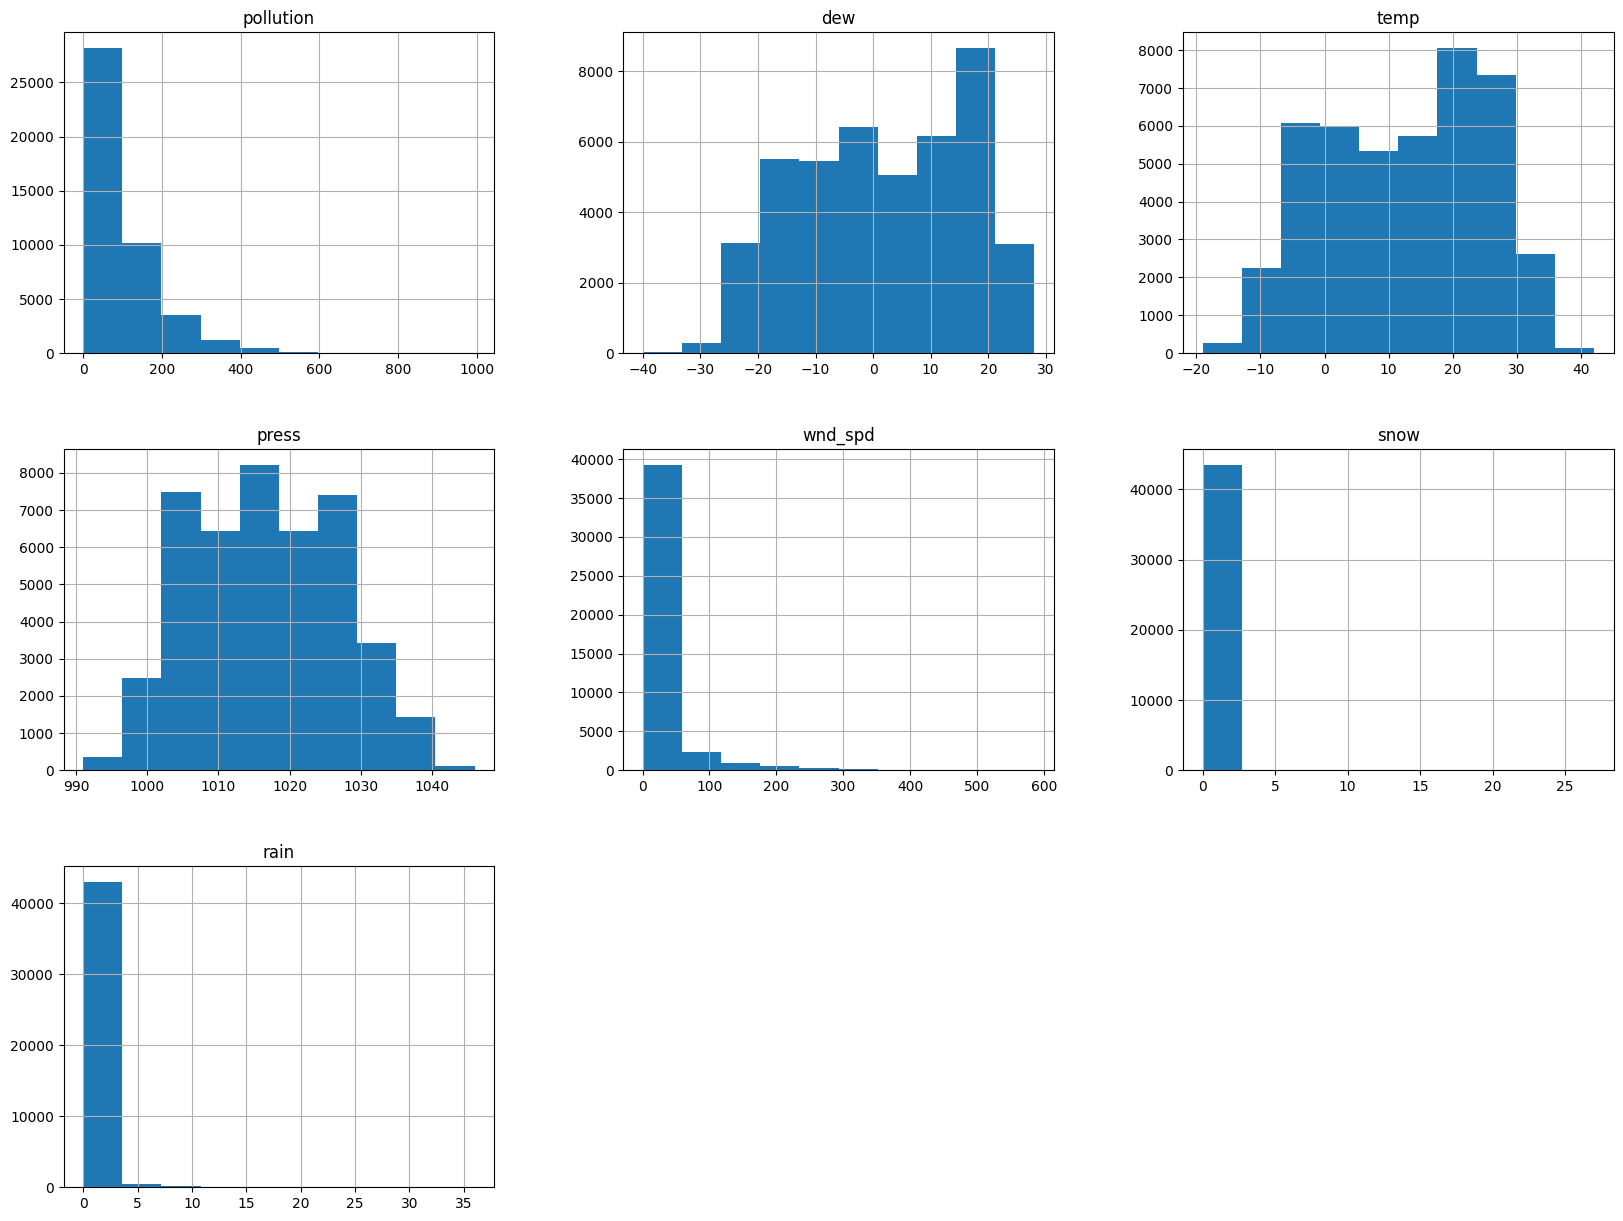

In [36]:
fig, ax = plt.subplots(figsize = (20,15))
df_pollution.hist(ax = ax)
plt.show()

## 2.4 Correlation Matrix


- **Pollution**: Shows a moderate positive correlation with `dew` (0.16) and `rain` (0.22), suggesting that higher pollution levels might be associated with increased dew and rainfall. It has a moderate negative correlation with `temp` (-0.91) and `press` (-0.46), indicating that pollution tends to be higher when temperatures and atmospheric pressure are lower.

- **Dew**: Strongly positively correlated with `temp` (0.82), meaning higher dew points are associated with higher temperatures. It has a strong negative correlation with `press` (-0.78), suggesting that lower pressure is associated with higher dew points.

- **Temperature (temp)**: As noted, it’s strongly correlated with `dew` (0.82) and negatively correlated with `press` (-0.83) and `pollution` (-0.91). This indicates that higher temperatures are associated with higher dew points, lower pressure, and lower pollution levels.

- **Pressure (press)**: Shows strong negative correlations with `dew` (-0.78), `temp` (-0.83), and moderate negative correlations with `pollution` (-0.46), `snow` (-0.69), and `rain` (-0.08). Higher pressure seems to be associated with drier, colder conditions and lower pollution.

- **Wind Speed (wnd_spd)**: Has weak correlations with most variables, with the strongest being a negative correlation with `temp` (-0.15), suggesting that higher wind speeds might occur with lower temperatures.

- **Snow**: Shows a moderate negative correlation with `press` (-0.69) and weak positive correlations with `pollution` (0.22) and `dew` (0.03), indicating that snow events might be more likely with lower pressure and slightly higher pollution.

- **Rain**: Has a weak positive correlation with `pollution` (0.22) and `dew` (0.13), and a very weak negative correlation with `press` (-0.08), suggesting that rainfall might slightly increase with higher pollution and dew but is not strongly tied to pressure.

<Axes: >

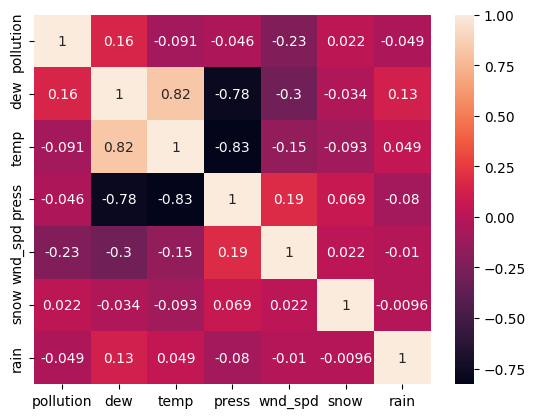

In [37]:
sns.heatmap(df_pollution[num_cols].corr(), annot = True)

## 2.5 Time Series Analysis

These time series plots show environmental variables in Beijing from 2010 to 2015:

- **Pollution**: High variability with frequent spikes above 800, especially in winters (e.g., early 2010, 2012, 2013), indicating seasonal pollution peaks.
- **Dew**: Clear seasonal pattern, peaking at 20°-30° in summers and dropping to -30° in winters, reflecting temperature-driven humidity changes.
- **Temperature (temp)**: Strong seasonal cycle, ranging from -10°C in winters to 30°C in summers, with consistent yearly patterns.
- **Pressure (press)**: Seasonal fluctuations between 990 and 1040 hpa, with higher pressure in winters and lower in summers, inversely related to temperature.
- **Wind Speed (wnd_spd)**: Mostly low, with occasional spikes up to 600 (?), showing no clear seasonal trend but frequent short bursts.
- **Snow**: Rare, with small peaks in winters (e.g., 2010, 2012, 2013), reaching up to 25 cms, consistent with cold seasons.
- **Rain**: Sporadic, with peaks in summers (e.g., 2010, 2012, 2014), reaching up to 35 mms, reflecting monsoon patterns.

### Summary
Seasonal patterns dominate temperature, dew, and pressure, while pollution peaks in winter. Wind speed, snow, and rain are more erratic, with snow and rain tied to specific seasons.

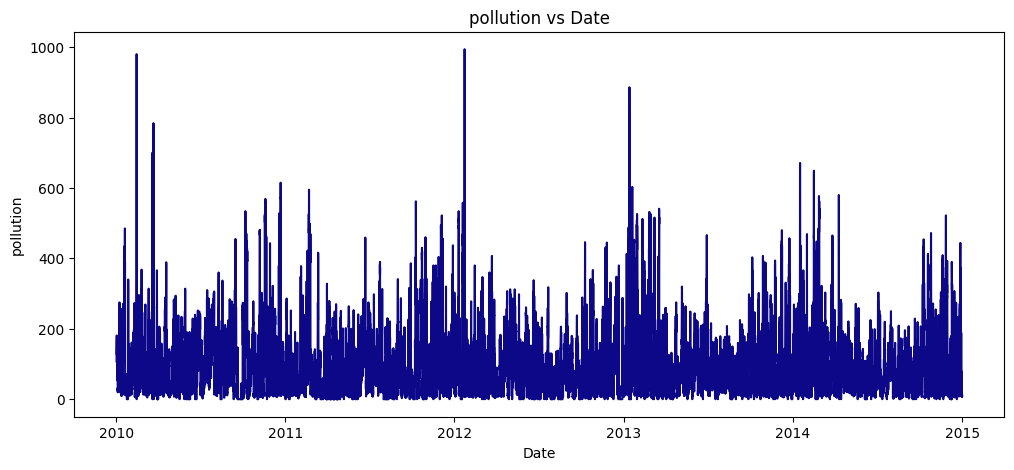

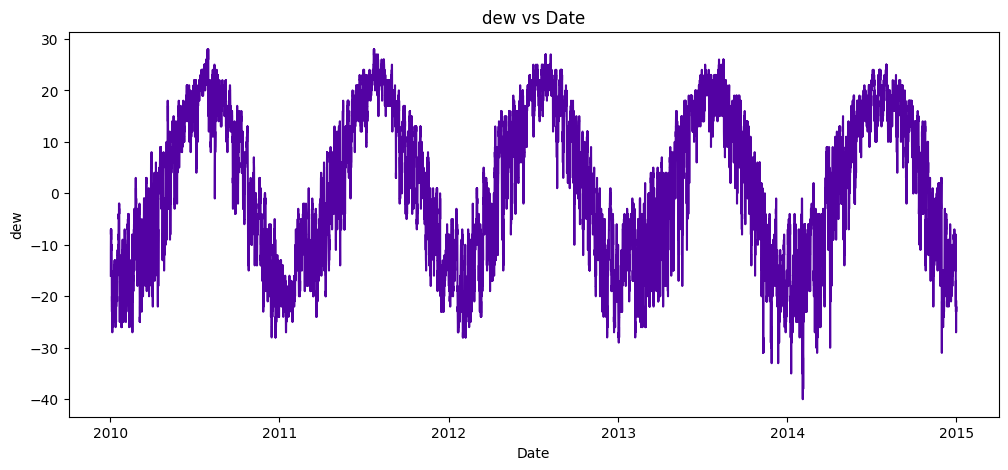

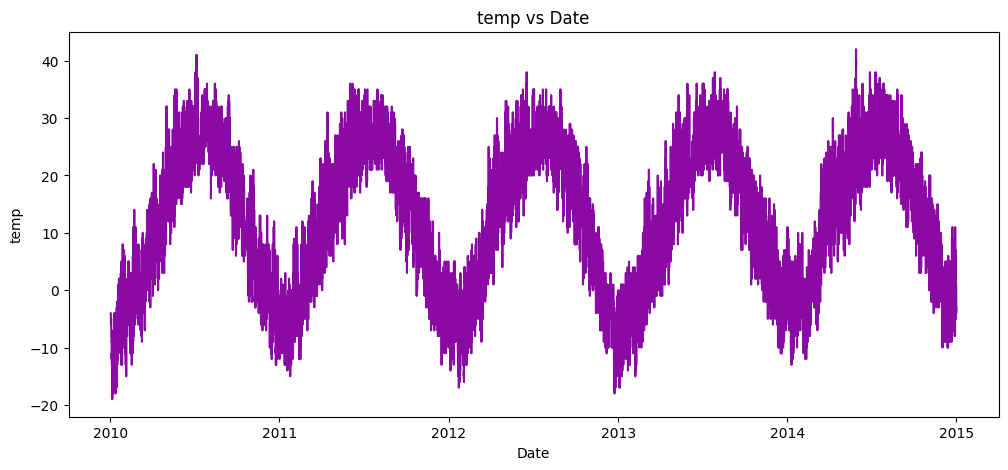

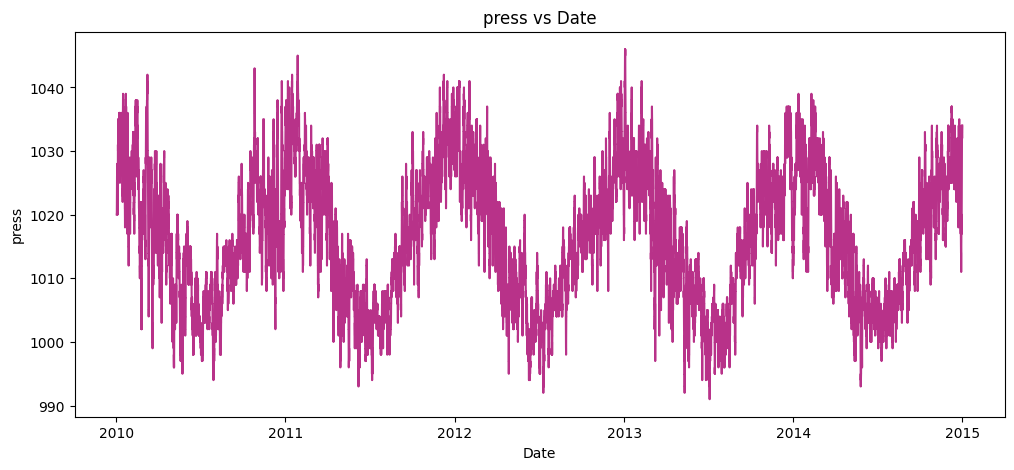

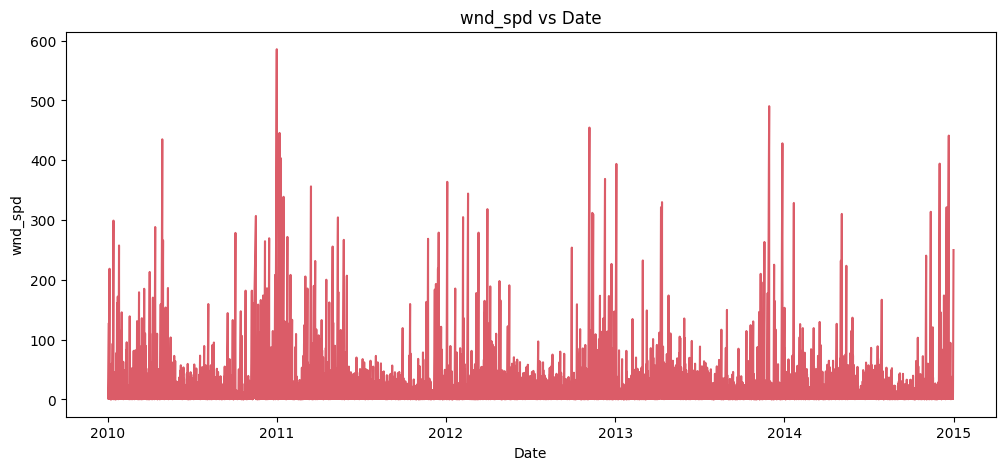

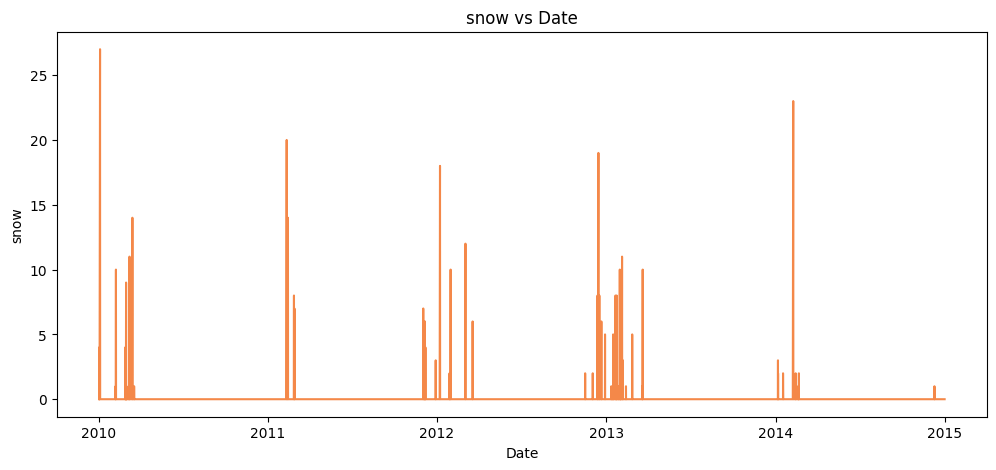

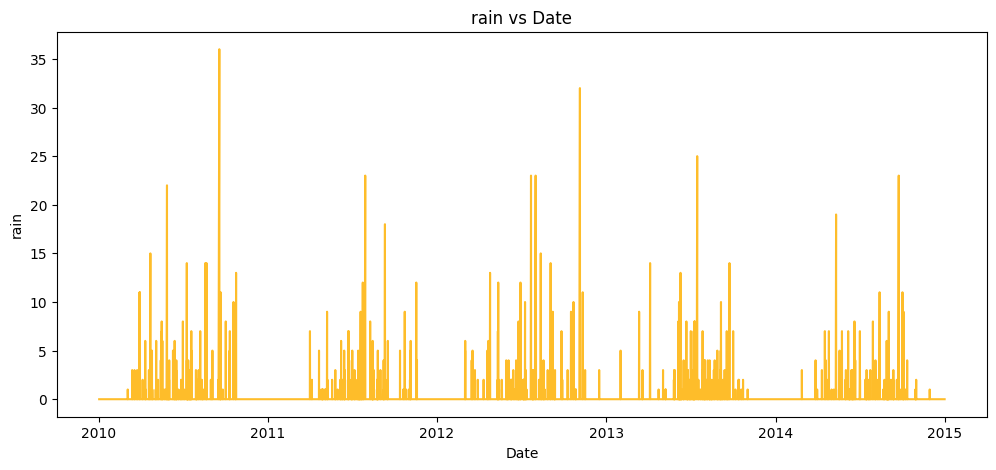

In [38]:
df_num = df_pollution[num_cols]
for i, col in enumerate(num_cols):
    plt.figure(figsize=(12, 5))
    color = cm.plasma(i / len(num_cols))
    plt.plot(df_pollution.index, df_num[col], color=color)
    plt.title(f"{col} vs Date")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.show()


## 2.6 Pollution Outlier Detection

- **General Trend**: Pollution levels fluctuate between 100 and 500 units, with periodic spikes indicating seasonal or episodic pollution events.
- **Outliers**: Red markers highlight extreme pollution levels exceeding 400-500 units, occurring sporadically across all years (e.g., early 2010, 2011, 2013, 2014). These likely represent significant pollution episodes, possibly linked to industrial activity, weather conditions, or seasonal factors.
- **Seasonal Patterns**: Higher peaks are noticeable in winters (e.g., 2010, 2012, 2013), consistent with the earlier correlation of pollution with lower temperatures and pressure.

### Summary
The plot reveals a baseline pollution level with occasional outliers above 400 units, predominantly in winter months. These outliers suggest periods of heightened pollution, which could be further analyzed alongside wind direction data from your windrose plot to identify potential sources or dispersion patterns.

In [39]:
df_pollution

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [40]:
from scipy.stats import zscore #ind of uneccesary but looks cool

df_daily = df_pollution
#df_daily.set_index('index', inplace = True)
df_daily = df_daily.resample("D").mean(numeric_only=True)
df_daily['pollution_zscore'] = zscore(df_daily["pollution"])
outliers_day = df_daily[df_daily['pollution_zscore'].abs() > 3]


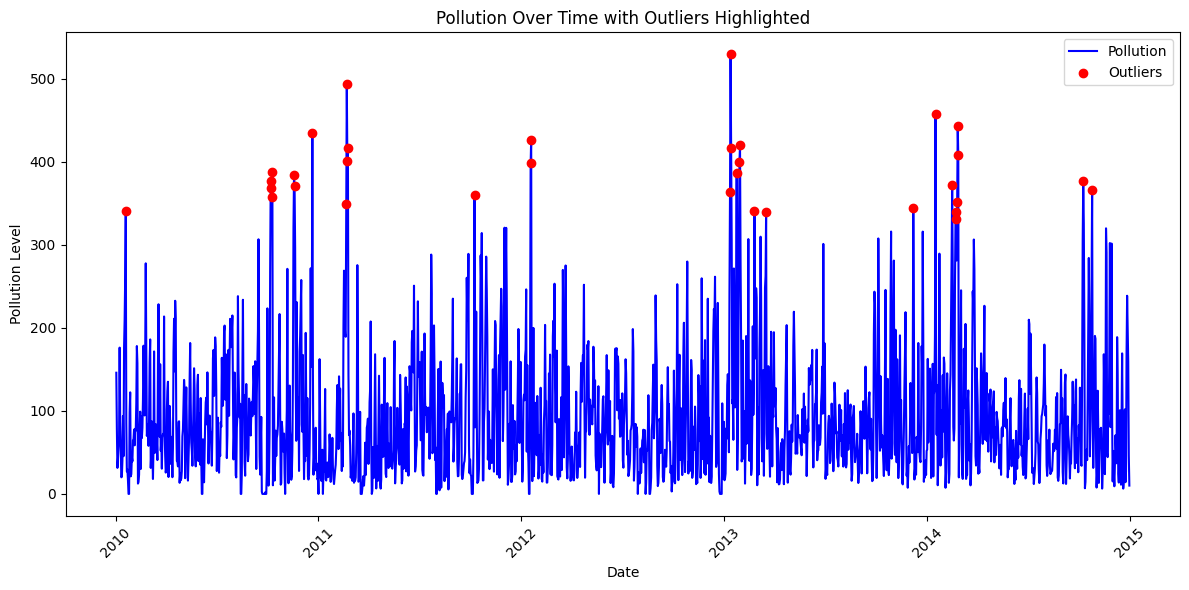

In [41]:

outliers_day.sort_values("pollution_zscore", ascending=False)
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['pollution'], label='Pollution', color='blue')
plt.scatter(outliers_day.index, outliers_day['pollution'], color='red', label='Outliers', zorder=5)
plt.xlabel('Date')
plt.ylabel('Pollution Level')
plt.title('Pollution Over Time with Outliers Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2.7 Wind Direction Analysis

These bar plots summarize the total sums of pollution, snow, and rain grouped by wind direction (NE, NW, SE, cv) in Beijing, based on your dataset:

- **Pollution by Wind Direction**: Highest pollution sums are observed with SE (around 1.4 million) and NW (around 1.0 million), indicating these directions may carry more polluted air masses. NE shows a lower sum (around 0.4 million), while cv is moderate (around 1.2 million).

- **Snow by Wind Direction**: SE has the highest snow sum (around 1200 units), followed by NW (around 400 units). NE and cv show lower sums (around 200 units), suggesting SE winds are more associated with snow events.

- **Rain by Wind Direction**: NW has the highest rain sum (around 2500 units), with SE and cv at similar levels (around 1500 units). NE shows the lowest sum (around 1500 units), indicating NW winds may bring more rainfall.

### Summary
SE winds correlate with the highest pollution and snow levels, while NW winds are linked to the most rain. These patterns align with your windrose data, where SE and NW were dominant directions, potentially influencing pollution and precipitation distribution in Beijing.

In [42]:
df_pollution["wnd_dir"].value_counts() #CV - Calm Variable Winds, which are non consisten Wind directions

wnd_dir
SE    15287
NW    14128
cv     9377
NE     4994
Name: count, dtype: int64

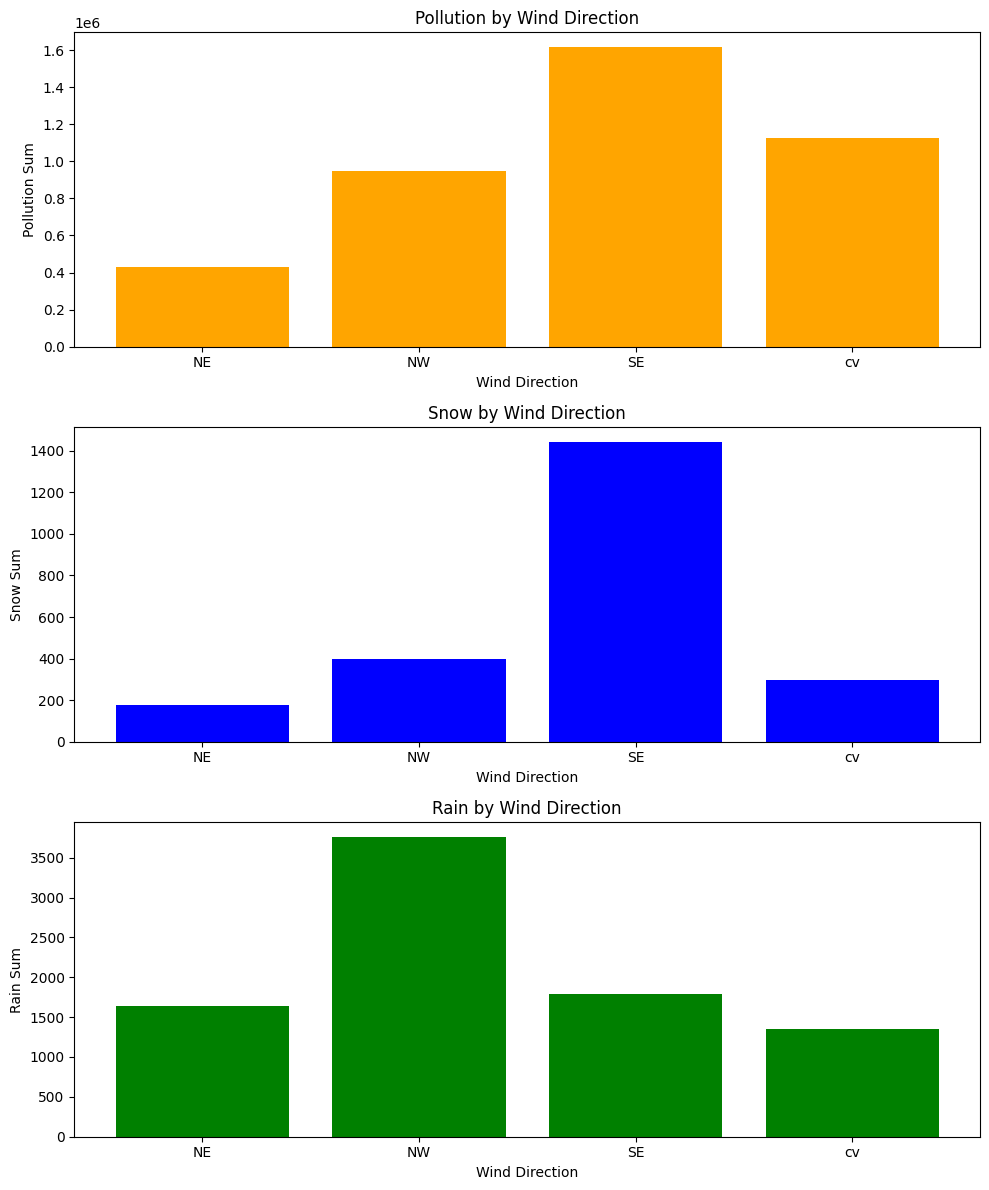

In [43]:
wind_grouped = df_pollution.groupby("wnd_dir").agg({
    "pollution": "sum",
    "snow": "sum",
    "rain": "sum"
})


x = np.arange(len(wind_grouped))
columns_to_plot = ['pollution', 'snow', 'rain']
titles = ['Pollution by Wind Direction', 'Snow by Wind Direction', 'Rain by Wind Direction']
colors = ['orange', 'blue', 'green']


fig, axs = plt.subplots(3, 1, figsize=(10, 12))
for i, col in enumerate(columns_to_plot):
    axs[i].bar(x, wind_grouped[col], color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Wind Direction')
    axs[i].set_ylabel(f'{col.capitalize()} Sum')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(wind_grouped.index)


plt.tight_layout()
plt.show()


# 3. Feature Engineering for the first trial

## 3.1 Dataset Aggregation

In [45]:
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

df_pollution["wnd_dir"] = df_pollution["wnd_dir"].map(mapping)
df_pollution_test["wnd_dir"] = df_pollution_test["wnd_dir"].map(mapping)

C:\Users\z003xbyx\AppData\Local\Temp\ipykernel_11364\353713519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pollution["wnd_dir"] = df_pollution["wnd_dir"].map(mapping)


In [46]:
aggregation = {
    'pollution': lambda x: round(x.mean(), 2),  # Mean, rounded to 2 decimals
    'dew': lambda x: round(x.mean(), 2),        # Mean, rounded to 2 decimals
    'temp': lambda x: round(x.mean(), 2),       # Mean, rounded to 2 decimals
    'press': lambda x: round(x.mean(), 2),      # Mean, rounded to 2 decimals
    'wnd_dir': lambda x: x.mode()[0],           # Mode, no rounding needed (integer)
    'wnd_spd': lambda x: round(x.mean(), 2),    # Mean, rounded to 2 decimals
    'snow': lambda x: round(x.sum(), 2),        # Sum, rounded to 2 decimals
    'rain': lambda x: round(x.sum(), 2)         # Sum, rounded to 2 decimals
}

df_pollution_daily = df_pollution.resample('D').agg(aggregation)

df_pollution_daily.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02,145.96,-8.50,-5.12,1024.75,1,24.86,17,0
2010-01-03,78.83,-10.12,-8.54,1022.79,1,70.94,340,0
2010-01-04,31.33,-20.88,-11.50,1029.29,2,111.16,0,0
2010-01-05,42.46,-24.58,-14.46,1033.62,2,56.92,0,0
2010-01-06,56.42,-23.71,-12.54,1033.75,0,18.51,0,0


## 3.2 Creating the Dependent

In [47]:
df_pollution["pollution"].describe()

count    43786.000000
mean        94.020006
std         92.261007
min          0.000000
25%         24.000000
50%         68.000000
75%        133.000000
max        994.000000
Name: pollution, dtype: float64

In [48]:
df_pollution["pollution"].median()

np.float64(68.0)

In [49]:
#outdated

def classify_pollution(value):
    if value < 35:
        return 0 #Low
    elif 35 <= value < 75:
        return 1 # Moderate
    elif 75 <= value < 132.25:
        return 2 # High
    else:  # >= 132.25
        return 3 # Very High

# Apply classification

In [50]:
def classify_pollution_2(value):
    if value < 68.0:
        return 0 #Low
    else:
        return 1


# Apply classification

df_pollution_daily['pollution_class'] = df_pollution_daily['pollution'].apply(classify_pollution_2)

In [51]:
df_pollution_daily['pollution_class'].value_counts()

pollution_class
1    983
0    842
Name: count, dtype: int64

In [52]:
df_pollution_daily.pollution_class.value_counts()

pollution_class
1    983
0    842
Name: count, dtype: int64

## 3.3 Feature Engineering

- ``dew``: was dropped as it was highly correlated with other features
  
- ``temp_press`` was added due to the strong negative correlation
  - For example, high temperatures with low pressure (e.g., warm, stormy conditions) may trap pollutants, while high pressure with low temperatures (e.g., cold, clear days) may disperse them. The product term models this synergistic effect.
  
- ``press_snow``: A moderate negative correlation (-0.69) exists between pressure and snow.
  - Low pressure systems often bring snow, which can coincide with stagnant air that traps pollutants. This interaction term highlights the combined effect of low pressure and snow accumulation on pollution, such as during winter storms where pollutants might accumulate due to reduced air movement.
  

In [53]:
df_pollution_daily.drop("dew", axis = 1, inplace = True)

In [54]:
df_pollution_daily['temp_press'] = df_pollution_daily['temp'] * df_pollution_daily['press']
df_pollution_daily['press_snow'] = df_pollution_daily['press'] * df_pollution_daily['snow']

In [55]:
df_pollution_daily.head()

,pollution,temp,press,wnd_dir,wnd_spd,snow,rain,pollution_class,temp_press,press_snow
date,,,,,,,,,,
2010-01-02,145.96,-5.12,1024.75,1,24.86,17,0,1,-5246.7200,17420.75
2010-01-03,78.83,-8.54,1022.79,1,70.94,340,0,1,-8734.6266,347748.60
2010-01-04,31.33,-11.50,1029.29,2,111.16,0,0,0,-11836.8350,0.00
2010-01-05,42.46,-14.46,1033.62,2,56.92,0,0,0,-14946.1452,0.00
2010-01-06,56.42,-12.54,1033.75,0,18.51,0,0,0,-12963.2250,0.00


## 3.4 Adding Time Effects

- ``DOW`` adding daily time effects (0: Monday, 6: Sunday)
  - Pollution levels differ during the weak, Records start on a Saturday
  
- ``is_weekend`` binary variable that checks wether a day is on the weekend
  - Pollution differs on the weekends, compared to Weekdays

- ``Season`` the overall weather depends on the season, and the pollution depends on the season
  - 0 = Winter, 1 = Spring, 2 = Summer and 3 = Autumn

In [56]:
df_pollution_daily["DOW"] = df_pollution_daily.index.dayofweek #Day of Week
df_pollution_daily['is_weekend'] = df_pollution_daily['DOW'].isin([5, 6]).astype(int) #Weekend

In [57]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0 #'Winter'
    elif month in [3, 4, 5]:
        return 1 #'Spring'
    elif month in [6, 7, 8]:
        return 2 #'Summer'
    else:  # 9, 10, 11
        return 3 #'Fall'

df_pollution_daily["month"] = df_pollution_daily.index.month
df_pollution_daily["Season"] = df_pollution_daily["month"].apply(get_season)
df_pollution_daily.drop("month", axis = 1, inplace = True)

# 4. Our first trials - models


## 4.1 SOFTMAX Regression - Baseline


### Key Predicitons
- As the SOFTMAX Regression is a Baseline Model, it was primariliy used to identify which features to select, and which methods could be used on further Models

1. **Most Important Features:**
   - `wnd_dir_1` (North East) , `press`, `wnd_dir_3` (Cumulative Wind), and `wnd_spd` are the most influential features, suggesting that **wind direction, speed, and pressure** are critical for predictions.
   - `temp` and `Season_2` (Spring) also have high importance, indicating that **temperature and seasonality significantly impact the outcome.**

2. **Moderate Importance:**
   - Features such as `temp_press`, `Season_1` (Winter), and `press_snow` contribute to the model but to a lesser extent.
   - These may still be relevant but not as dominant as the top features.

3. **Least Important Features:**
   - `DOW_2`, `DOW_5`, and `is_weekend_1` show the **lowest importance**, suggesting that **day-of-the-week effects and weekend status have minimal influence** on predictions.

### Suggestions

- **Remove Irrelevant Features:** Exclude unnecessary columns (such as the Day of the Week, if not relevant to the target variable) to reduce noise and improve model performance.

- **Dimensionality Reduction with PCA:** Apply Principal Component Analysis (PCA) to reduce the dimensionality of the feature space while retaining important variance. This could help simplify the model and improve its performance by eliminating multicollinearity.

- **Address Class Imbalance:** Consider using SMOTE (Synthetic Minority Over-sampling Technique) for oversampling the minority classes, or alternatively, apply class-weight adjustments in models like Random Forest to balance the class distribution and improve model accuracy, especially for underrepresented categories.

- **Hyperparameter Tuning:** Perform hyperparameter tuning (e.g., using GridSearchCV or RandomizedSearchCV) to optimize the performance of your model, especially for Random Forests or other tree-based algorithms. This could help improve both accuracy and robustness by identifying the best combination of parameters.

In [58]:
numeric_cols = ['temp', 'press', 'wnd_spd', 'snow', 'rain',
                'temp_press', 'press_snow']
categorical_cols = ['Season', 'wnd_dir']

In [59]:
df_categorical = pd.get_dummies(df_pollution_daily[categorical_cols], columns=categorical_cols, drop_first=True)


X = pd.concat([df_pollution_daily[numeric_cols], df_categorical], axis=1)
y = df_pollution_daily['pollution_class']

dfFull = pd.concat([X, y], axis = 1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
# Step 3: Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Baseline Model
Cross-Validation Accuracy Scores: [0.80800113 0.7787214  0.75848077 0.74125973 0.75380986]
Mean Accuracy: 0.7681 ± 0.0233
Test Accuracy: 0.6986

Classification Report:
              precision    recall  f1-score   support

         Low       0.71      0.58      0.64       168
        High       0.69      0.80      0.74       197

    accuracy                           0.70       365
   macro avg       0.70      0.69      0.69       365
weighted avg       0.70      0.70      0.69       365


Confusion Matrix:


<Axes: >

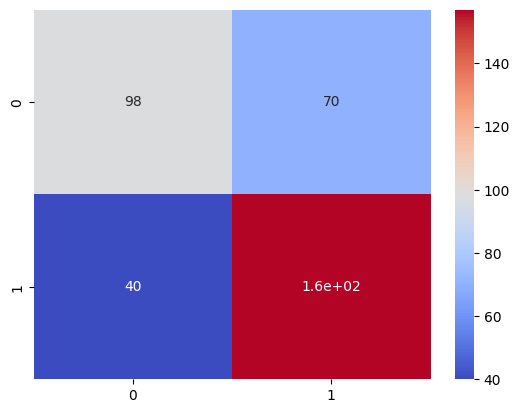

In [62]:
softmax_model = LogisticRegression(solver='liblinear', random_state=42, penalty = 'l1')

# Step 2: Perform Cross-Validation
cv_scores = cross_val_score(softmax_model, X_train_scaled, y_train, cv=5, scoring='roc_auc_ovo')  # 5-fold CV

# Print cross-validation accuracy#
print('Baseline Model')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Step 3: Train the model on the full training data
softmax_model.fit(X_train_scaled, y_train)

# Step 4: Predict and evaluate on test data
y_pred = softmax_model.predict(X_test_scaled)
y_pred_proba = softmax_model.predict_proba(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'High']))

# Confusion matrix
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="coolwarm")

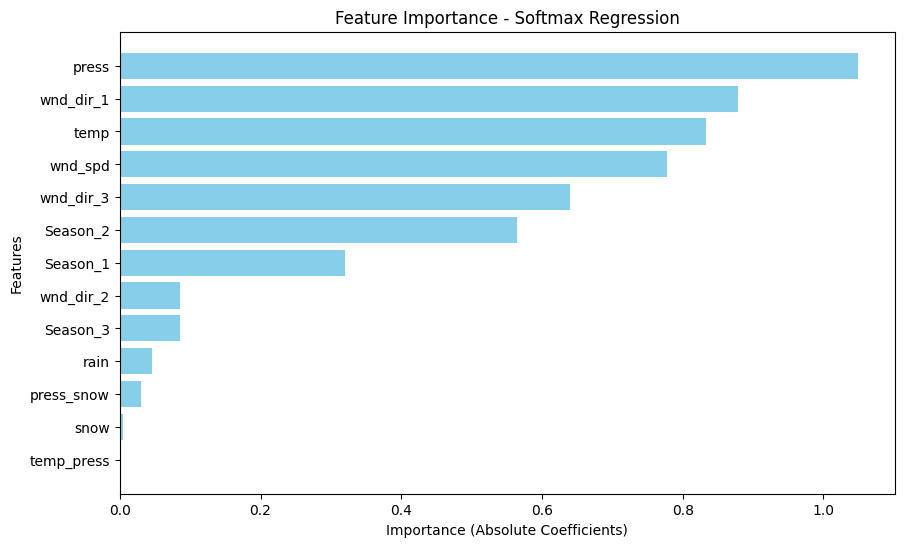

In [64]:
feature_importance = np.abs(softmax_model.coef_).mean(axis=0)  # Average across classes

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance (Absolute Coefficients)")
plt.ylabel("Features")
plt.title("Feature Importance - Softmax Regression")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

## 4.2 Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np


# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6821917808219178
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.59      0.63       168
           1       0.68      0.76      0.72       197

    accuracy                           0.68       365
   macro avg       0.68      0.68      0.68       365
weighted avg       0.68      0.68      0.68       365



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight' : [None,'balanced_subsample', 'balanced']
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Perform GridSearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit to data (X_train, y_train should be defined)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the best model
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate
y_pred = best_rf.predict(X_test)
print("Improved Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Improved Accuracy: 0.7123287671232876
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.59      0.65       168
           1       0.70      0.82      0.75       197

    accuracy                           0.71       365
   macro avg       0.72      0.70      0.70       365
weighted avg       0.72      0.71      0.71       365



In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='roc_auc_ovo')  # 5-fold CV

# Print cross-validation accuracy
print('Random Forest Model')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train Random Forest model
rf_model = RandomForestClassifier(bootstrap=True,class_weight= None,max_depth = 10, min_samples_leaf=4, min_samples_split= 2,n_estimators = 200,random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Model
Cross-Validation Accuracy Scores: [0.76905819 0.79254541 0.71995754 0.74284029 0.75970748]
Mean Accuracy: 0.7568 ± 0.0244
Accuracy: 0.7123287671232876
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.59      0.65       168
           1       0.70      0.82      0.75       197

    accuracy                           0.71       365
   macro avg       0.72      0.70      0.70       365
weighted avg       0.72      0.71      0.71       365



In [67]:
confusion_matrix(y_test, y_pred)

array([[ 99,  69],
       [ 36, 161]])

# 5. Next approach: Attempt with daily aggregation

As our first results were not promising, we tried a different approach. For that we also imported the data new.

In [68]:
import pandas as pd

dataset_url = "https://raw.githubusercontent.com/davidedalce/Air-Quality-Forecast/main/data/LSTM-Multivariate_pollution.csv"
df_pollution = pd.read_csv(dataset_url)

In [69]:
df_pollution['date'] = pd.to_datetime(df_pollution['date'])
df_pollution.set_index('date', inplace=True)

## Vector components for wind
No need for intensity and direction

In [70]:
import numpy as np
wind_direction_mapping = {
    'N': 0, 'NE': 45, 'E': 90, 'SE': 135, 'S': 180, 'SW': 225, 'W': 270, 'NW': 315
}
df_pollution['wnd_dir_degrees'] = df_pollution['wnd_dir'].map(wind_direction_mapping)
df_pollution['wnd_dir_radians'] = np.radians(df_pollution['wnd_dir_degrees'])

# Calculate the wind vector components (X and Y) for each hour
df_pollution['wind_x'] = df_pollution['wnd_spd'] * np.sin(df_pollution['wnd_dir_radians'])
df_pollution['wind_y'] = df_pollution['wnd_spd'] * np.cos(df_pollution['wnd_dir_radians'])
aggregation = {
    'pollution': lambda x: round(x.mean(), 2),   # Mean, rounded to 2 decimals
    'dew': lambda x: round(x.mean(), 2),         # Mean, rounded to 2 decimals
    'temp': lambda x: round(x.mean(), 2),        # Mean, rounded to 2 decimals
    'press': lambda x: round(x.mean(), 2),       # Mean, rounded to 2 decimals     # Mean, rounded to 2 decimals
    'snow': lambda x: round(x.sum(), 2),         # Sum, rounded to 2 decimals
    'rain': lambda x: round(x.sum(), 2),         # Sum, rounded to 2 decimals
    'wind_x': lambda x: round(x.mean(), 2),      # Mean of wind_x component
    'wind_y': lambda x: round(x.mean(), 2)       # Mean of wind_y component
}
df_pollution_daily = df_pollution.resample('D').agg(aggregation)

df_pollution_daily.head()

,pollution,dew,temp,press,snow,rain,wind_x,wind_y
date,,,,,,,,
2010-01-02,145.96,-8.50,-5.12,1024.75,17,0,17.58,-17.58
2010-01-03,78.83,-10.12,-8.54,1022.79,340,0,52.28,-52.28
2010-01-04,31.33,-20.88,-11.50,1029.29,0,0,-78.60,78.60
2010-01-05,42.46,-24.58,-14.46,1033.62,0,0,-28.77,41.97
2010-01-06,56.42,-23.71,-12.54,1033.75,0,0,10.02,14.22


In [71]:
df_pollution_daily.drop("dew", axis = 1, inplace = True)

In [72]:
df_pollution_daily['temp_press'] = df_pollution_daily['temp'] * df_pollution_daily['press']
df_pollution_daily['press_snow'] = df_pollution_daily['press'] * df_pollution_daily['snow']

In [73]:
df_pollution_daily["DOW"] = df_pollution_daily.index.dayofweek #Day of Week
df_pollution_daily['is_weekend'] = df_pollution_daily['DOW'].isin([5, 6]).astype(int) #Weekend

In [74]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0 #'Winter'
    elif month in [3, 4, 5]:
        return 1 #'Spring'
    elif month in [6, 7, 8]:
        return 2 #'Summer'
    else:  # 9, 10, 11
        return 3 #'Fall'

df_pollution_daily["month"] = df_pollution_daily.index.month
df_pollution_daily["Season"] = df_pollution_daily["month"].apply(get_season)
df_pollution_daily.drop("month", axis = 1, inplace = True)

## Attempt with Regression before Multi-Class classification through usage of daily, weekly, and yearly lags

In [75]:
lags = [1, 7, 365]
for lag in lags:
    df_pollution_daily[f'pollution_lag_{lag}'] = df_pollution_daily['pollution'].shift(lag)
df_pollution_daily.dropna(inplace=True)

Including the weekly rolling average

In [76]:
df_pollution_daily['pollution_rolling_mean_7'] = df_pollution_daily['pollution'].rolling(window=7).mean()
df_pollution_daily['pollution_rolling_mean_7'].fillna(method='bfill', inplace=True)
df_pollution_daily.isnull().sum()

C:\Users\z003xbyx\AppData\Local\Temp\ipykernel_11364\645240936.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pollution_daily['pollution_rolling_mean_7'].fillna(method='bfill', inplace=True)
C:\Users\z003xbyx\AppData\Local\Temp\ipykernel_11364\645240936.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pollution_daily['pollution_rolling_mean_7'].fillna(method='bfill', inplace=True)


pollution                   0
temp                        0
press                       0
snow                        0
rain                        0
wind_x                      0
wind_y                      0
temp_press                  0
press_snow                  0
DOW                         0
is_weekend                  0
Season                      0
pollution_lag_1             0
pollution_lag_7             0
pollution_lag_365           0
pollution_rolling_mean_7    0
dtype: int64

In [77]:
df_pollution_daily['high_temp'] = (df_pollution_daily['temp'] > 30).astype(int)

In [78]:
df_pollution_daily = pd.get_dummies(df_pollution_daily, columns=['Season'], drop_first=False)

Correlations

In [79]:
df_pollution_daily.corr()

,pollution,temp,press,snow,rain,wind_x,wind_y,temp_press,press_snow,DOW,is_weekend,pollution_lag_1,pollution_lag_7,pollution_lag_365,pollution_rolling_mean_7,high_temp,Season_0,Season_1,Season_2,Season_3
pollution,1.000000,-0.126403,0.027568,0.055091,-0.049320,0.256322,-0.274959,-0.126252,0.054936,0.033934,0.026599,0.566884,0.055861,0.007068,0.488187,-0.040134,0.142671,-0.078444,-0.089932,0.026942
temp,-0.126403,1.000000,-0.881674,-0.139187,0.096035,0.311598,-0.331280,0.999945,-0.139159,0.003139,0.005567,-0.103280,-0.140183,-0.085277,-0.234304,0.102772,-0.770028,0.084431,0.671890,0.008146
press,0.027568,-0.881674,1.000000,0.115994,-0.128621,-0.299213,0.323835,-0.878820,0.116126,0.013372,0.010881,0.070743,0.104531,0.089054,0.185821,-0.095218,0.641288,-0.133671,-0.664483,0.162734
snow,0.055091,-0.139187,0.115994,1.000000,-0.014508,0.040888,-0.041187,-0.139756,0.999990,0.041286,0.017339,0.077100,0.052994,-0.062121,0.079088,-0.006628,0.157554,-0.038421,-0.059924,-0.058486
rain,-0.049320,0.096035,-0.128621,-0.014508,1.000000,-0.016125,0.015808,0.095888,-0.014510,0.028290,0.045192,0.050054,-0.031571,-0.015926,-0.007436,-0.010479,-0.108615,-0.043034,0.109365,0.041796
wind_x,0.256322,0.311598,-0.299213,0.040888,-0.016125,1.000000,-0.987717,0.311918,0.040980,0.008206,0.015596,0.089075,0.012805,0.005494,0.063410,0.014713,-0.208781,0.052835,0.206110,-0.052067
wind_y,-0.274959,-0.331280,0.323835,-0.041187,0.015808,-0.987717,1.000000,-0.331628,-0.041283,-0.000268,-0.011191,-0.077347,-0.011912,-0.007288,-0.056099,-0.016160,0.224035,-0.054143,-0.218397,0.050509
temp_press,-0.126252,0.999945,-0.878820,-0.139756,0.095888,0.311918,-0.331628,1.000000,-0.139729,0.003401,0.005861,-0.102617,-0.139967,-0.085167,-0.233948,0.101607,-0.773371,0.086648,0.667268,0.013910
press_snow,0.054936,-0.139159,0.116126,0.999990,-0.014510,0.040980,-0.041283,-0.139729,1.000000,0.041323,0.017520,0.076997,0.052992,-0.062086,0.078816,-0.006625,0.157549,-0.038468,-0.059896,-0.058461
DOW,0.033934,0.003139,0.013372,0.041286,0.028290,0.008206,-0.000268,0.003401,0.041323,1.000000,0.790922,0.029289,0.031292,0.013567,-0.001533,0.016214,-0.005983,0.001989,0.005149,-0.001207


Standardization

In [80]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
numeric_features = ['pollution', 'temp', 'press', 'snow', 'rain', 'wind_x', 'wind_y',
                    'temp_press', 'press_snow', 'pollution_lag_1', 'pollution_lag_7', 'pollution_lag_365',
                    'pollution_rolling_mean_7']
scaler = StandardScaler()
df_pollution_daily[numeric_features] = scaler.fit_transform(df_pollution_daily[numeric_features])
wind_scaler = MinMaxScaler()
df_pollution_daily[['wind_x', 'wind_y']] = wind_scaler.fit_transform(df_pollution_daily[['wind_x', 'wind_y']])
df_pollution_daily.head()

,pollution,temp,press,snow,rain,wind_x,wind_y,temp_press,press_snow,DOW,is_weekend,pollution_lag_1,pollution_lag_7,pollution_lag_365,pollution_rolling_mean_7,high_temp,Season_0,Season_1,Season_2,Season_3
date,,,,,,,,,,,,,,,,,,,,
2011-01-02,-0.733736,-1.542433,1.843228,-0.103036,-0.193173,0.685928,0.339303,-1.554539,-0.102988,6,1,-1.206788,-0.548118,0.685055,-0.708984,0,True,False,False,False
2011-01-03,0.888005,-1.636941,1.408480,-0.103036,-0.193173,0.683985,0.319593,-1.649275,-0.102988,0,0,-0.733401,-0.171611,-0.191860,-0.708984,0,True,False,False,False
2011-01-04,-0.028081,-1.542433,1.049935,-0.103036,-0.193173,0.648353,0.351978,-1.551042,-0.102988,1,0,0.888273,-0.838685,-0.812350,-0.708984,0,True,False,False,False
2011-01-05,-0.945717,-1.549433,1.485660,-0.103036,-0.193173,0.384743,0.615257,-1.560128,-0.102988,2,0,-0.027775,-0.729318,-0.666960,-0.708984,0,True,False,False,False
2011-01-06,-1.002133,-1.549433,2.111892,-0.103036,-0.193173,0.083890,0.916110,-1.562932,-0.102988,3,0,-0.945373,-0.975749,-0.484601,-0.708984,0,True,False,False,False


In [81]:
df_pollution_daily = pd.get_dummies(df_pollution_daily, columns=['DOW'], drop_first=False)

In [82]:
df_pollution_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1456 entries, 2011-01-02 to 2014-12-31
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pollution                 1456 non-null   float64
 1   temp                      1456 non-null   float64
 2   press                     1456 non-null   float64
 3   snow                      1456 non-null   float64
 4   rain                      1456 non-null   float64
 5   wind_x                    1456 non-null   float64
 6   wind_y                    1456 non-null   float64
 7   temp_press                1456 non-null   float64
 8   press_snow                1456 non-null   float64
 9   is_weekend                1456 non-null   int64  
 10  pollution_lag_1           1456 non-null   float64
 11  pollution_lag_7           1456 non-null   float64
 12  pollution_lag_365         1456 non-null   float64
 13  pollution_rolling_mean_7  1456 non-null   flo

Data preparation

In [83]:
X = df_pollution_daily.drop(columns=['pollution'])
y = df_pollution_daily['pollution']
split_index = int(0.8 * len(df_pollution_daily))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

## 5.1 Regression before classification

Regression to avoid reducing variance of the data

In [85]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_reg = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best Hyperparameters: ", best_params)
best_rf_reg = random_search.best_estimator_
y_pred_reg = best_rf_reg.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)
print("Mean Squared Error: ", mse)
print("R-squared: ", r2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\z003xbyx\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
165 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
101 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\z003xbyx\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\z003xbyx\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\z003xbyx\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Best Hyperparameters:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Mean Squared Error:  0.350061022520079
R-squared:  0.5453592717621591


In [86]:
low_threshold = np.percentile(y_train, 25)
high_threshold = np.percentile(y_train, 75)
def categorize_pollution(value):
    if value <= low_threshold:
        return "Low"
    elif value <= high_threshold:
        return "Medium"
    else:
        return "High"
y_test_class = np.array([categorize_pollution(y) for y in y_test])
y_pred_class = np.array([categorize_pollution(y) for y in y_pred_reg])

Evaluation

In [87]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

accuracy = accuracy_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class, output_dict=True)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", pd.DataFrame(class_report).transpose())

Accuracy: 0.6883561643835616
Confusion Matrix:
 [[ 33   0  22]
 [  0  20  49]
 [ 15   5 148]]
Classification Report:
               precision    recall  f1-score     support
High           0.687500  0.600000  0.640777   55.000000
Low            0.800000  0.289855  0.425532   69.000000
Medium         0.675799  0.880952  0.764858  168.000000
accuracy       0.688356  0.688356  0.688356    0.688356
macro avg      0.721100  0.590269  0.610389  292.000000
weighted avg   0.707352  0.688356  0.661303  292.000000


Poor performance especially on the identification of low: the model is biased towards the medium, for its greater number in the sample and the not so different patterns in the data characterizing it.

## 5.2 Classification

Trying directly multi-class classification

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Define the classes based on percentiles
low_threshold = np.percentile(y_train, 50)
#high_threshold = np.percentile(y_train, 90)
def categorize_pollution_class(value):
    if value <= low_threshold:
        return 0 #Low
    #elif value <= high_threshold:
    #    return 1 #Medium
    else:
        return 1  # High class
y_train_class = np.array([categorize_pollution_class(y) for y in y_train])
y_test_class = np.array([categorize_pollution_class(y) for y in y_test])
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=30, bootstrap=True)
rf_clf.fit(X_train, y_train_class)
y_pred_class = rf_clf.predict(X_test)
# Evaluate the performance
accuracy = accuracy_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class, output_dict=True)
# Print the results
print("Best Hyperparameters: ", best_params)
print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", pd.DataFrame(class_report).transpose())


Best Hyperparameters:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Accuracy:  0.7363013698630136
Confusion Matrix:
 [[106  46]
 [ 31 109]]
Classification Report:
               precision    recall  f1-score     support
0              0.773723  0.697368  0.733564  152.000000
1              0.703226  0.778571  0.738983  140.000000
accuracy       0.736301  0.736301  0.736301    0.736301
macro avg      0.738474  0.737970  0.736274  292.000000
weighted avg   0.739923  0.736301  0.736162  292.000000


# 6. Final approach

As also the last approach was not promising, we tried a different approach. For that we also imported the data new.

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score

In [90]:
dataset_url = "https://raw.githubusercontent.com/davidedalce/Air-Quality-Forecast/main/data/LSTM-Multivariate_pollution.csv"
df_hourly = pd.read_csv(dataset_url)

In [91]:
df_hourly['wnd_dir'].value_counts()

wnd_dir
SE    15290
NW    14130
cv     9384
NE     4996
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

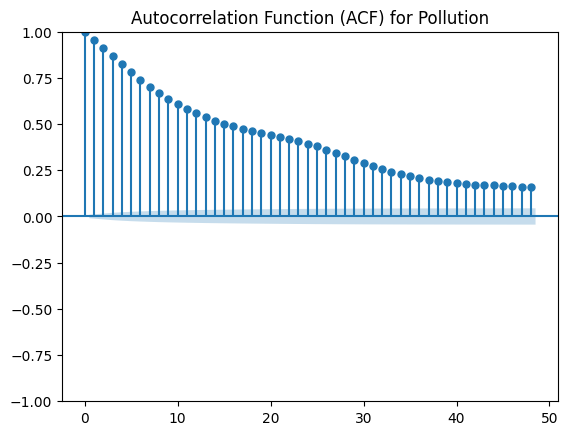

<Figure size 1000x600 with 0 Axes>

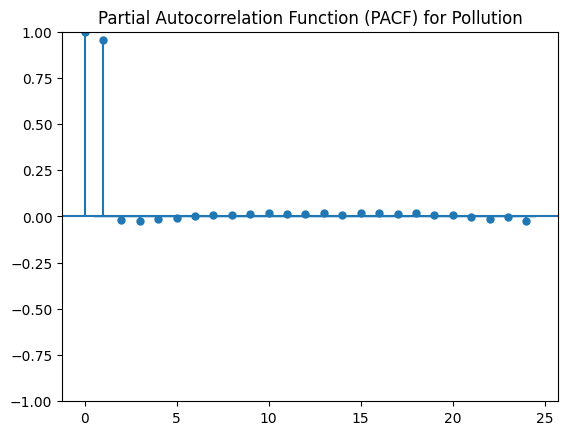

In [92]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df_hourly' is the dataframe and 'pollution' is the column of interest
plt.figure(figsize=(10, 6))
plot_acf(df_hourly["pollution"], lags=48)  # Adjust lags to 48 hours (or another appropriate value)
plt.title('Autocorrelation Function (ACF) for Pollution')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(df_hourly["pollution"], lags=24)  # Same for PACF
plt.title('Partial Autocorrelation Function (PACF) for Pollution')
plt.show()


In [93]:
df_hourly['date'] = pd.to_datetime(df_hourly['date'])
df_hourly['DOW'] = df_hourly['date'].dt.weekday
df_hourly['is_weekend'] = df_hourly['DOW'].isin([5, 6]).astype(int)
df_hourly['high_temp'] = (df_hourly['temp'] > 30).astype(int)
df_hourly['low_temp'] = (df_hourly['temp'] < 0).astype(int)
df_hourly['pollution_lag_24'] = df_hourly['pollution'].shift(24)
df_hourly['pollution_lag_24'].fillna(method='bfill', inplace=True)
df_hourly['pollution_rolling_mean_24'] = df_hourly['pollution'].rolling(window=24).mean()
df_hourly['pollution_rolling_mean_24'].fillna(method='bfill', inplace=True)
wind_direction_mapping = {
    'N': 0, 'NE': 45, 'E': 90, 'SE': 135, 'S': 180, 'SW': 225, 'W': 270, 'NW': 315
}
df_hourly['wnd_dir_degrees'] = df_hourly['wnd_dir'].map(wind_direction_mapping)
df_hourly['wnd_dir_radians'] = np.radians(df_hourly['wnd_dir_degrees'])
df_hourly['wind_x'] = df_hourly['wnd_spd'] * np.sin(df_hourly['wnd_dir_radians'])
df_hourly['wind_y'] = df_hourly['wnd_spd'] * np.cos(df_hourly['wnd_dir_radians'])
df_hourly['wind_x'].fillna(0, inplace=True)
df_hourly['wind_y'].fillna(0, inplace=True)
df_hourly['Season'] = df_hourly['date'].dt.month % 12 // 3 + 1  # Assigning season (1: Spring, 2: Summer, 3: Fall, 4: Winter)
df_hourly = df_hourly.drop(columns=['date', 'wnd_dir', 'wnd_dir_degrees', 'wnd_spd', 'wnd_dir_radians'])

C:\Users\z003xbyx\AppData\Local\Temp\ipykernel_11364\278520801.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hourly['pollution_lag_24'].fillna(method='bfill', inplace=True)
C:\Users\z003xbyx\AppData\Local\Temp\ipykernel_11364\278520801.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly['pollution_lag_24'].fillna(method='bfill', inplace=True)
C:\Users\z003xbyx\AppData\Local\Temp\ipykernel_11364\278520801.py:9: FutureWarn

In [94]:
df_hourly.isnull().sum()

pollution                    0
dew                          0
temp                         0
press                        0
snow                         0
rain                         0
DOW                          0
is_weekend                   0
high_temp                    0
low_temp                     0
pollution_lag_24             0
pollution_rolling_mean_24    0
wind_x                       0
wind_y                       0
Season                       0
dtype: int64

In [95]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import pandas as pd

# Copy dataset
df_scaled = df_hourly.copy()

### 1. Log Transform Right-Skewed Features
log_transform_features = ['pollution', 'pollution_lag_24', 'pollution_rolling_mean_24']
for col in log_transform_features:
    df_scaled[col] = np.log1p(df_scaled[col])  # log1p ensures log(0) is handled

### 2. Standard Scaling (Z-score Normalization) for Normally Distributed Features
scaler = StandardScaler()
standard_features = ['dew', 'temp', 'press', 'wind_x', 'wind_y']
df_scaled[standard_features] = scaler.fit_transform(df_scaled[standard_features])

### 3. Binary Encoding for Features That Indicate Presence/Absence
binary_features = ['snow', 'rain', 'is_weekend', 'high_temp', 'low_temp']
df_scaled[binary_features] = df_scaled[binary_features].astype(int)  # Already binary, ensure format

### 4. Cyclical Encoding for Periodic Features
# Encoding Day of the Week (DOW)
df_scaled['DOW_sin'] = np.sin(2 * np.pi * df_scaled['DOW'] / 7)
df_scaled['DOW_cos'] = np.cos(2 * np.pi * df_scaled['DOW'] / 7)
df_scaled.drop(columns=['DOW'], inplace=True)

# Encoding Season
df_scaled = pd.get_dummies(df_scaled, columns=['Season'], prefix='Season')
df_hourly=df_scaled
### Final Check
print("Feature Scaling and Encoding Completed.")


Feature Scaling and Encoding Completed.


In [96]:
df_hourly.describe()

,pollution,dew,temp,press,snow,rain,is_weekend,high_temp,low_temp,pollution_lag_24,pollution_rolling_mean_24,wind_x,wind_y,DOW_sin,DOW_cos
count,43800.000000,4.380000e+04,4.380000e+04,4.380000e+04,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,4.380000e+04,4.380000e+04,4.380000e+04,43800.000000
mean,3.968538,-2.076472e-17,-8.825006e-17,5.009489e-15,0.052763,0.195023,0.286027,0.045160,0.196119,3.969905,4.171948,1.816913e-17,2.595590e-18,-2.076472e-17,0.000987
std,1.317020,1.000011e+00,1.000011e+00,1.000011e+00,0.760582,1.416247,0.451907,0.207657,0.397064,1.316649,1.030008,1.000011e+00,1.000011e+00,7.073564e-01,0.706873
min,0.000000,-2.898887e+00,-2.580038e+00,-2.477517e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.054936e+01,-5.103804e+00,-9.749279e-01,-0.900969
25%,3.218876,-8.197646e-01,-8.577734e-01,-8.224188e-01,0.000000,0.000000,0.000000,0.000000,0.000000,3.218876,3.661423,8.697363e-02,-2.681435e-01,-7.818315e-01,-0.900969
50%,4.234107,1.188454e-02,1.263781e-01,-4.354913e-02,0.000000,0.000000,0.000000,0.000000,0.000000,4.234107,4.316376,1.604941e-01,-1.941958e-01,0.000000e+00,-0.222521
75%,4.892222,9.128378e-01,8.644917e-01,8.326793e-01,0.000000,0.000000,1.000000,0.000000,0.000000,4.892222,4.853006,2.749813e-01,-7.904354e-02,7.818315e-01,0.623490
max,6.902743,1.813791e+00,2.422732e+00,2.877212e+00,27.000000,36.000000,1.000000,1.000000,1.000000,6.902743,6.472861,5.041743e+00,1.057788e+01,9.749279e-01,1.000000


In [97]:
low_threshold = np.percentile(df_hourly['pollution'], 25)
high_threshold = np.percentile(df_hourly['pollution'], 75)

def categorize_pollution(value):
    if value <= low_threshold:
        return 0  # Low
    elif value <= high_threshold:
        return 1  # Medium
    else:
        return 2  # High

df_hourly['pollution_class'] = df_hourly['pollution'].apply(categorize_pollution)

In [98]:
X = df_hourly.drop(columns=['pollution', 'pollution_class'])
y = df_hourly['pollution_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [99]:
logistic_clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000, multi_class='auto') # increase max_iter if not converging
logistic_clf.fit(X_train, y_train)

# Make predictions
y_pred = logistic_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Print results
print("Logistic Regression Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", pd.DataFrame(class_report).transpose())

c:\Users\z003xbyx\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy:  0.7430365296803653
Confusion Matrix:
 [[1386  748   64]
 [ 414 3559  399]
 [   3  623 1564]]
Classification Report:
               precision    recall  f1-score      support
0              0.768719  0.630573  0.692827  2198.000000
1              0.721907  0.814044  0.765212  4372.000000
2              0.771584  0.714155  0.741760  2190.000000
accuracy       0.743037  0.743037  0.743037     0.743037
macro avg      0.754070  0.719591  0.733266  8760.000000
weighted avg   0.746072  0.743037  0.741186  8760.000000


## 6.1 RANDOM FOREST

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=30, bootstrap=True)
rf_clf.fit(X_train, y_train)

y_pred_proba = rf_clf.predict_proba(X_test)
threshold_class_2 = 0.32
y_pred_class_thresholded = np.argmax(y_pred_proba, axis=1)
y_pred_class_thresholded[y_pred_proba[:, 2] > threshold_class_2] = 2  # Assign class 2 (High) based on the threshold
accuracy = accuracy_score(y_test, y_pred_class_thresholded)
conf_matrix = confusion_matrix(y_test, y_pred_class_thresholded)
class_report = classification_report(y_test, y_pred_class_thresholded, output_dict=True)

# Print results
print("Accuracy with adjusted threshold: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", pd.DataFrame(class_report).transpose())

Accuracy with adjusted threshold:  0.8168949771689498
Confusion Matrix:
 [[1657  486   55]
 [ 250 3574  548]
 [   6  259 1925]]
Classification Report:
               precision    recall  f1-score      support
0              0.866179  0.753867  0.806130  2198.000000
1              0.827506  0.817475  0.822460  4372.000000
2              0.761472  0.878995  0.816024  2190.000000
accuracy       0.816895  0.816895  0.816895     0.816895
macro avg      0.818386  0.816779  0.814871  8760.000000
weighted avg   0.820701  0.816895  0.816754  8760.000000


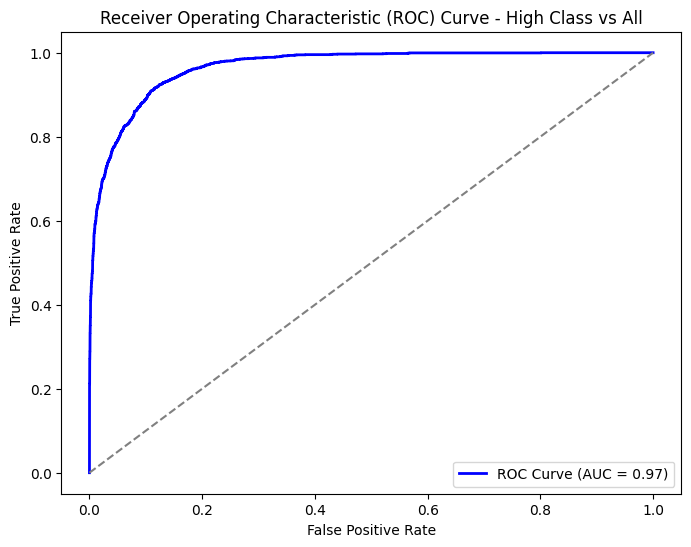

AUC for class 2 (High) vs All: 0.97


In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred_proba' contains the predicted probabilities
# for each class (e.g., 3 classes). We will calculate the ROC curve for class 2 (High).

# Calculate ROC curve for class 2 (High) vs all (one-vs-rest approach)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 2], pos_label=2)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - High Class vs All')
plt.legend(loc='lower right')
plt.show()

# Print the AUC value
print(f'AUC for class 2 (High) vs All: {roc_auc:.2f}')


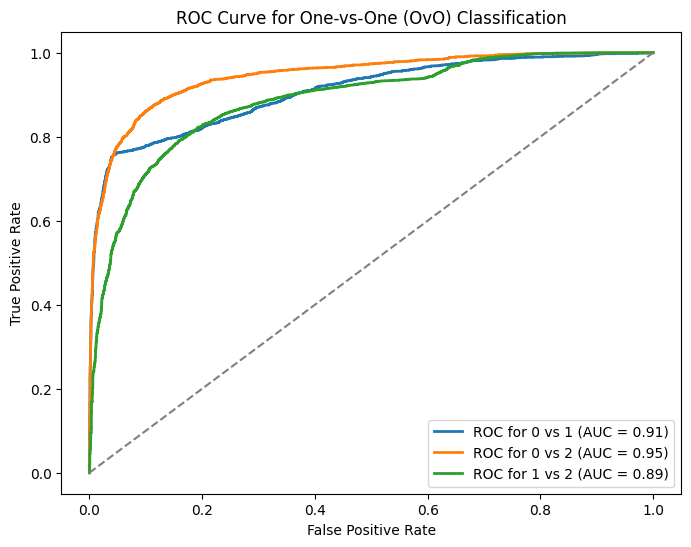

In [102]:
from sklearn.metrics import roc_curve, auc
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'y_test' contains the true labels and 'y_pred_proba' contains the predicted probabilities

# Get all pairs of classes for One-vs-One
classes = np.unique(y_test)  # Get unique classes
class_pairs = list(combinations(classes, 2))  # All pairs of classes

# Initialize plot
plt.figure(figsize=(8, 6))

# Loop through each pair of classes
for class_1, class_2 in class_pairs:
    # Create binary labels for class_1 vs class_2
    y_test_bin = np.where(y_test == class_1, 1, 0)  # Class_1 as positive class
    y_pred_proba_bin = y_pred_proba[:, class_1] - y_pred_proba[:, class_2]  # Difference between class probabilities for class_1 and class_2

    # Compute ROC curve and AUC for each class pair
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba_bin)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each class pair
    plt.plot(fpr, tpr, lw=2, label=f'ROC for {class_1} vs {class_2} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Finalizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for One-vs-One (OvO) Classification')
plt.legend(loc='lower right')
plt.show()


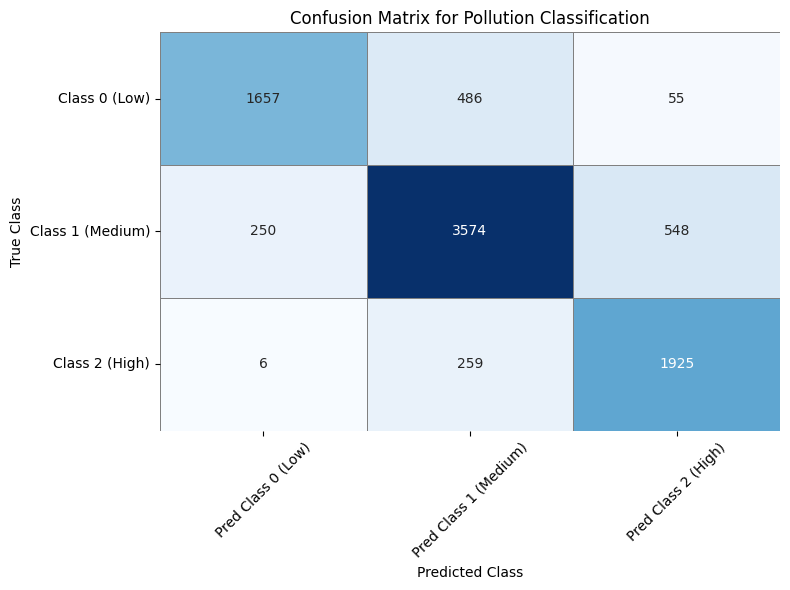

<Figure size 640x480 with 0 Axes>

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming 'y_test' are the true labels and 'y_pred_class_thresholded' are the predicted labels
# You can use 'y_pred_class_thresholded' based on the adjusted threshold

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class_thresholded)

# Create a dataframe for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix,
                               index=["Class 0 (Low)", "Class 1 (Medium)", "Class 2 (High)"],
                               columns=["Pred Class 0 (Low)", "Pred Class 1 (Medium)", "Pred Class 2 (High)"])

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5, linecolor='gray')

# Add labels and title
plt.title('Confusion Matrix for Pollution Classification')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()

# Optionally, save the confusion matrix as an image
plt.savefig("confusion_matrix.png", format="png")


In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=30, bootstrap=True)
rf_clf.fit(X_train, y_train)

y_pred_proba = rf_clf.predict_proba(X_test)
threshold_class_2 = 0.5
y_pred_class_thresholded = np.argmax(y_pred_proba, axis=1)
y_pred_class_thresholded[y_pred_proba[:, 2] > threshold_class_2] = 2  # Assign class 2 (High) based on the threshold
accuracy = accuracy_score(y_test, y_pred_class_thresholded)
conf_matrix = confusion_matrix(y_test, y_pred_class_thresholded)
class_report = classification_report(y_test, y_pred_class_thresholded, output_dict=True)

# Print results
print("Accuracy without adjusted threshold: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", pd.DataFrame(class_report).transpose())

Accuracy without adjusted threshold:  0.8246575342465754
Confusion Matrix:
 [[1659  498   41]
 [ 251 3857  264]
 [   6  476 1708]]
Classification Report:
               precision    recall  f1-score      support
0              0.865866  0.754777  0.806514  2198.000000
1              0.798385  0.882205  0.838205  4372.000000
2              0.848485  0.779909  0.812753  2190.000000
accuracy       0.824658  0.824658  0.824658     0.824658
macro avg      0.837579  0.805630  0.819157  8760.000000
weighted avg   0.827842  0.824658  0.823890  8760.000000


In [105]:
feature_importances = rf_clf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                      Feature  Importance
9   pollution_rolling_mean_24    0.363654
11                     wind_y    0.116869
8            pollution_lag_24    0.110379
10                     wind_x    0.099902
0                         dew    0.097517
1                        temp    0.061919
2                       press    0.055813
12                    DOW_sin    0.025629
13                    DOW_cos    0.018925
14                   Season_1    0.008855
4                        rain    0.007321
15                   Season_2    0.007146
5                  is_weekend    0.006587
17                   Season_4    0.006318
7                    low_temp    0.004552
16                   Season_3    0.004302
6                   high_temp    0.002584
3                        snow    0.001728


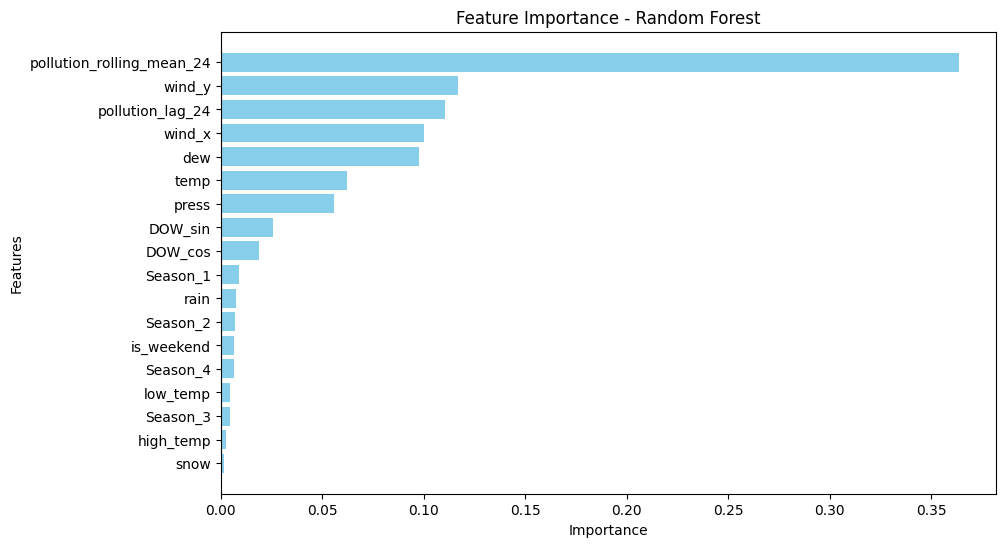

In [106]:


# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

## 6.2 XGBOOST

In [107]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define XGBoost model with hyperparameters
xgb_clf = XGBClassifier(
    random_state=42,
    n_estimators=100,      # Number of boosting rounds
    max_depth=6,           # Maximum tree depth
    learning_rate=0.1,     # Step size shrinkage
    subsample=0.8,         # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    min_child_weight=3,    # Minimum sum of instance weight
    gamma=0.1              # Regularization parameter
)

# Train the XGBoost model
xgb_clf.fit(X_train, y_train)

# Predict class probabilities
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)

# Apply threshold adjustment for Class 2 (High pollution)
threshold_class_2 = 0.32
y_pred_class_xgb = np.argmax(y_pred_proba_xgb, axis=1)
y_pred_class_xgb[y_pred_proba_xgb[:, 2] > threshold_class_2] = 2

# Evaluate model performance
accuracy_xgb = accuracy_score(y_test, y_pred_class_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_class_xgb)
class_report_xgb = classification_report(y_test, y_pred_class_xgb, output_dict=True)

# Print results
print("XGBoost Accuracy with Adjusted Threshold: ", accuracy_xgb)
print("XGBoost Confusion Matrix:\n", conf_matrix_xgb)
print("XGBoost Classification Report:\n", pd.DataFrame(class_report_xgb).transpose())


XGBoost Accuracy with Adjusted Threshold:  0.7872146118721461
XGBoost Confusion Matrix:
 [[1636  506   56]
 [ 338 3386  648]
 [   5  311 1874]]
XGBoost Classification Report:
               precision    recall  f1-score      support
0              0.826680  0.744313  0.783337  2198.000000
1              0.805615  0.774474  0.789738  4372.000000
2              0.726920  0.855708  0.786074  2190.000000
accuracy       0.787215  0.787215  0.787215     0.787215
macro avg      0.786405  0.791498  0.786383  8760.000000
weighted avg   0.791227  0.787215  0.787216  8760.000000


In [108]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #stratified kfold is best for classification
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation CV Accuracy:", np.std(cv_scores))

Cross-Validation Scores: [0.8173516  0.80693493 0.8077911  0.81321347 0.81107306]
Mean CV Accuracy: 0.8112728310502284
Standard Deviation CV Accuracy: 0.003786746662046614


In [109]:
feature_importances = rf_clf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                      Feature  Importance
9   pollution_rolling_mean_24    0.363654
11                     wind_y    0.116869
8            pollution_lag_24    0.110379
10                     wind_x    0.099902
0                         dew    0.097517
1                        temp    0.061919
2                       press    0.055813
12                    DOW_sin    0.025629
13                    DOW_cos    0.018925
14                   Season_1    0.008855
4                        rain    0.007321
15                   Season_2    0.007146
5                  is_weekend    0.006587
17                   Season_4    0.006318
7                    low_temp    0.004552
16                   Season_3    0.004302
6                   high_temp    0.002584
3                        snow    0.001728
